In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import h5py
from pathlib import Path

from sklearn.linear_model import Ridge,Lasso
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import flammkuchen as fl

from scipy.interpolate import interp1d

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# from megabouts_helper import labels_cat, color

# Load Bouts

In [5]:
# master_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Raw_Data')

# fish_paths = list(master_path.glob('*f[0-9]*'))
# fish_paths, len(fish_paths)


([WindowsPath('//portulab.synology.me/data/Kata/testdata/Raw_Data/240423_f0')],
 1)

In [6]:
# fish= 0
# fish_path = fish_paths[fish]
# fish_id =  fish_paths[fish].name#[:-13]
# exp_name = Path(fish_paths[fish]).parts[-2]
# exp_name = 'testfish'
# exp_name, fish_id

('testfish', '240423_f0')

In [7]:
# out_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Processed_Data')

### Load DLC

In [8]:
fps=200
mm_per_unit = 1/70
N_seg = 10

In [9]:
df = pd.read_csv(master_path/ 'DLC_mod.csv', header=[0, 1])


In [10]:
df.head()

bodyparts left_eye_anterior                        left_eye_posterior  \
     coords                 x           y likelihood                  x   
0         0        645.326900  521.443017   0.999891         654.856002   
1         1        646.183150  519.644351   0.999896         656.078755   
2         2        650.207855  517.061760   0.999923         659.556388   
3         3        654.625610  513.145553   0.999913         664.477157   
4         4        657.924704  510.390997   0.999740         667.236973   

                         right_eye_anterior                         ...  \
            y likelihood                  x           y likelihood  ...   
0  553.228951   0.999758         606.735142  539.762843   0.999914  ...   
1  551.395331   0.999851         607.531952  537.669198   0.999881  ...   
2  549.311521   0.999905         611.376284  534.990023   0.999691  ...   
3  545.056029   0.999953         616.157773  530.418686   0.999719  ...   
4  542.307606   0.999960         619.216163  528.236603   0.999846  ...   

      tail_8      tail_9                            tail_10              \
  likelihood           x           y likelihood           x           y   
0   0.998467  463.398844  250.457989   0.998467  439.471039  239.365433   
1   0.998625  473.571332  246.601053   0.998625  444.348114  245.641525   
2   0.999190  491.481593  238.960160   0.999190  461.540009  236.261642   
3   0.997801  503.204287  227.416002   0.997801  476.081390  216.947006   
4   0.998626  506.768862  217.844257   0.998626  485.563690  199.774689   

                mid_head                         
  likelihood           x           y likelihood  
0   0.998467  633.807176  544.905587   0.998467  
1   0.998625  634.773111  542.948934   0.998625  
2   0.999190  638.426775  540.509511   0.999190  
3   0.997801  643.096984  536.308950   0.997801  
4   0.998626  646.209680  533.732044   0.998626  

[5 rows x 64 columns]

In [16]:
print(f'{df.shape[0]/(fps*60)} minutes at {fps} fps')
print('working on {} frames'.format(df.shape[0]))

#Extract angles
body_x = df.body.values[:, 0].astype('float')
body_y = df.body.values[:, 1].astype('float')



7.9519166666666665 minutes at 200 fps
working on 95423 frames


## Run new Megabouts Pipeline

### Create tracking data

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cycler import cycler

from megabouts.tracking_data import TrackingConfig, FullTrackingData, load_example_data
from megabouts.pipeline import FullTrackingPipeline
from megabouts.utils import (
    bouts_category_name,
    bouts_category_name_short,
    bouts_category_color,
    cmp_bouts,
)

In [19]:
# Load data and set tracking configuration
tracking_cfg = TrackingConfig(fps=fps, tracking="full_tracking")

# Compute head and tail coordinates and convert to mm
tail_x_col = [f'tail_{i}' for i in range(N_seg)]
tail_y_col = [f'tail_{i}' for i in range(N_seg)]
tail_x = np.array([df[x].iloc[:, 0].values.astype('float') for x in tail_x_col]) * mm_per_unit
tail_y = np.array([df[x].iloc[:, 1].values.astype('float') for x in tail_y_col]) * mm_per_unit
head_x = df.mid_head.values[:, 0].astype('float') * mm_per_unit
head_y = df.mid_head.values[:, 1].astype('float') * mm_per_unit


In [20]:
# Create FullTrackingData object
tracking_data = FullTrackingData.from_keypoints(
    head_x=head_x, head_y=head_y, tail_x=tail_x.T, tail_y=tail_y.T
)

In [21]:
pipeline = FullTrackingPipeline(tracking_cfg, exclude_CS=True)

In [22]:
pipeline.segmentation_cfg.threshold = 20

In [23]:
pipeline.tail_preprocessing_cfg.tail_speed_filter_ms = 50

In [25]:
pipeline.tail_preprocessing_cfg

TailPreprocessingConfig(fps=200, limit_na_ms=100, num_pcs=4, savgol_window_ms=15, baseline_method='median', baseline_params={'fps': 200, 'half_window': 100}, tail_speed_filter_ms=50, tail_speed_boxcar_filter_ms=14)

In [26]:
ethogram, bouts, segments, tail, traj = pipeline.run(tracking_data)

C:\Users\admin\miniconda3\envs\megabouts\Lib\site-packages\megabouts\classification\classification.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(t

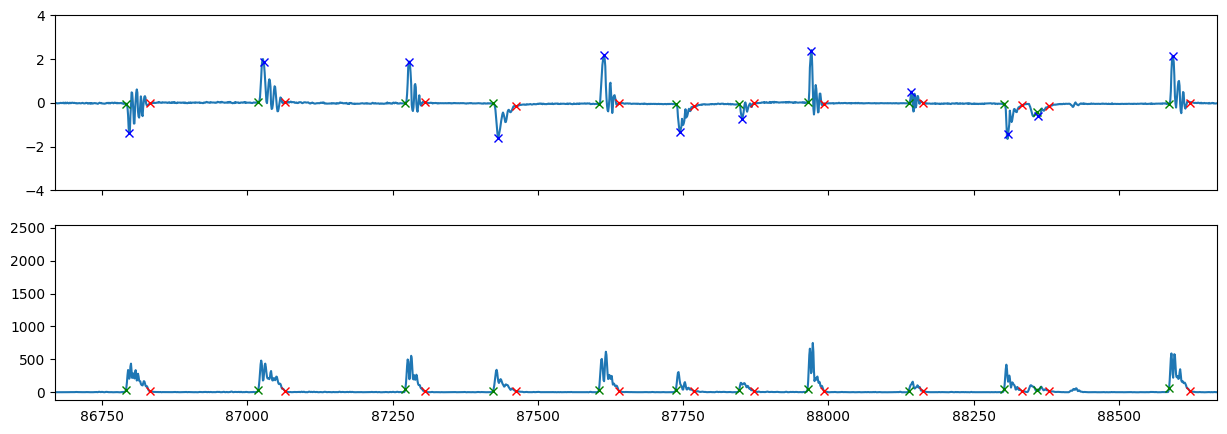

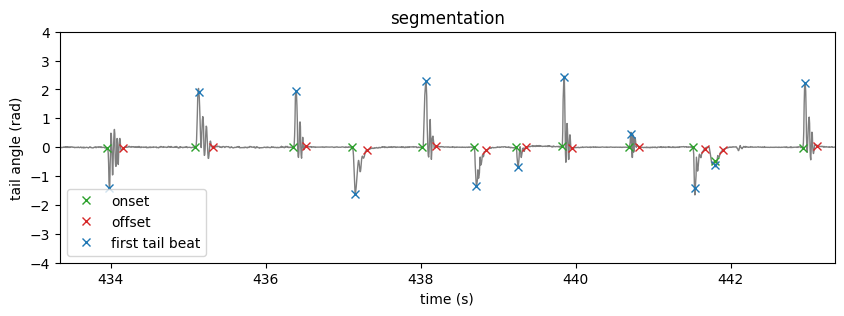

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

x = tracking_data._tail_angle[:, 7]
ax[0].plot(x)
ax[0].plot(segments.onset, x[segments.onset], "x", color="green")
ax[0].plot(segments.offset, x[segments.offset], "x", color="red")
ax[0].plot(segments.HB1, x[segments.HB1], "x", color="blue")
ax[0].set_ylim(-4, 4)

x = tail.vigor
ax[1].plot(x)
ax[1].plot(segments.onset, x[segments.onset], "x", color="green")
ax[1].plot(segments.offset, x[segments.offset], "x", color="red")

t = np.arange(tracking_data.T) / tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10 * tracking_cfg.fps
ax[1].set_xlim(IdSt, IdSt + Duration)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
x = tail.df.angle_smooth.iloc[:, 7]
ax.plot(t, x, color="tab:grey", lw=1)
ax.plot(t[segments.onset], x[segments.onset], "x", color="tab:green", label="onset")
ax.plot(t[segments.offset], x[segments.offset], "x", color="tab:red", label="offset")
ax.plot(
    t[segments.HB1], x[segments.HB1], "x", color="tab:blue", label="first tail beat"
)
ax.set(
    **{
        "title": "segmentation",
        "xlim": (t[IdSt], t[IdSt + Duration]),
        "ylim": (-4, 4),
        "ylabel": "tail angle (rad)",
        "xlabel": "time (s)",
    }
)
ax.legend()
plt.show()

## Visualise results

(342,)


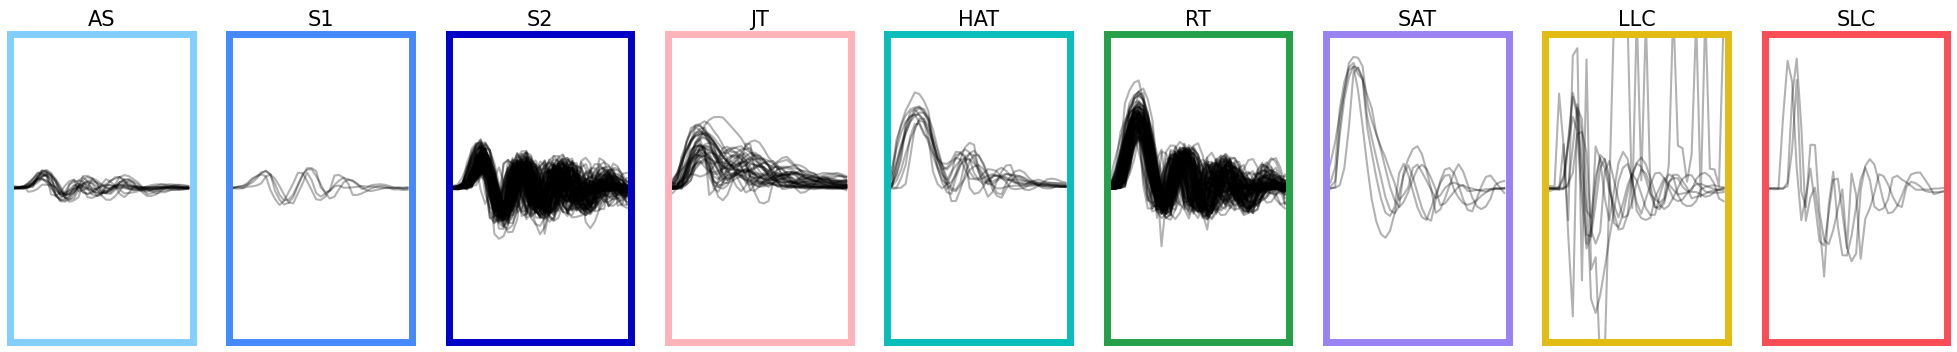

In [28]:
thr_proba = 0.9

id_b = np.unique(bouts.df.label.category[bouts.df.label.proba > thr_proba]).astype("int")
print(bouts.df.label.category[bouts.df.label.proba > thr_proba].shape)
fig, ax = plt.subplots(facecolor="white", figsize=(25, 4))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
G = gridspec.GridSpec(1, len(id_b))
ax0 = {}
for i, b in enumerate(id_b):
    ax0 = plt.subplot(G[i])
    ax0.set_title(bouts_category_name_short[b], fontsize=15)
    for i_sg, sg in enumerate([1, -1]):
        id = bouts.df[
            (bouts.df.label.category == b)
            & (bouts.df.label.sign == sg)
            & (bouts.df.label.proba > thr_proba)
        ].index
        if len(id) > 0:
            ax0.plot(sg * bouts.tail[id, 7, :].T, color="k", alpha=0.3)
        ax0.set_xlim(0, pipeline.segmentation_cfg.bout_duration)
        ax0.set_ylim(-4, 4)
        ax0.set_xticks([])
        ax0.set_yticks([])
        for sp in ["top", "bottom", "left", "right"]:
            ax0.spines[sp].set_color(bouts_category_color[b])
            ax0.spines[sp].set_linewidth(5)

plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_23496\3850899793.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  ethogram.df[("bout", "cat")].values[IdSt:IdEd].T,
C:\Users\admin\AppData\Local\Temp\ipykernel_23496\3850899793.py:44: PerformanceWarning: indexing past lexsort depth may impact performance.
  id_b = np.unique(ethogram.df[("bout", "id")].values[IdSt:IdEd]).astype("int")


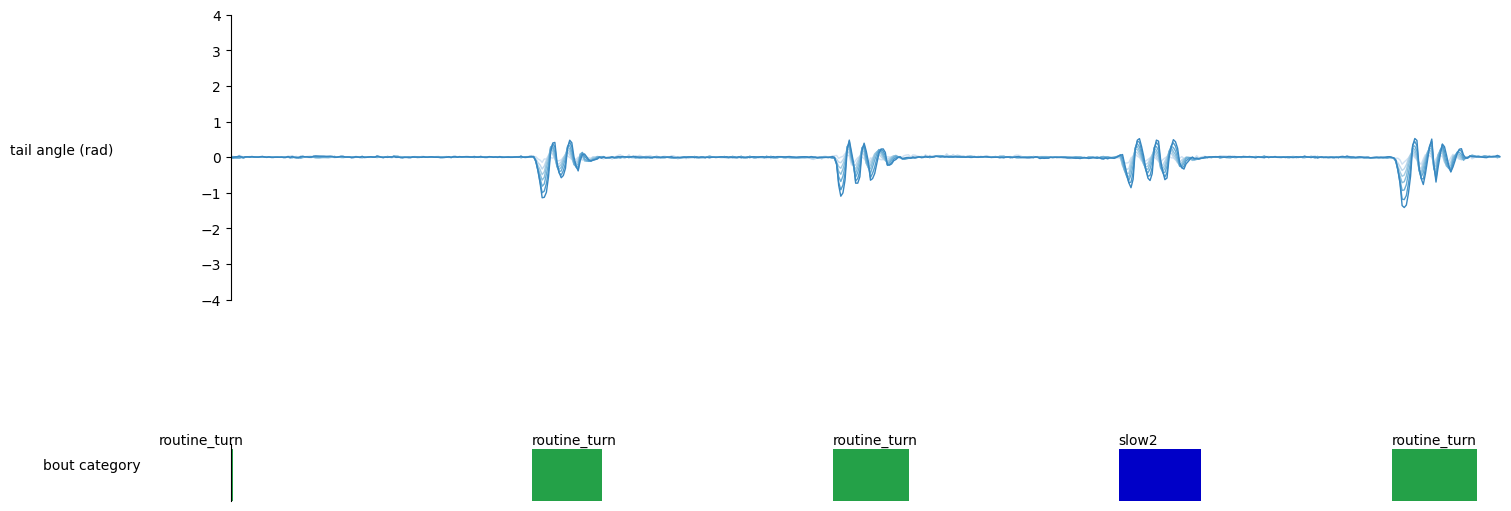

In [29]:
IdSt = np.random.randint(tracking_data.T)
T = 3
Duration = T * tracking_cfg.fps
IdEd = IdSt + Duration
t = np.arange(Duration) / tracking_cfg.fps


fig = plt.figure(facecolor="white", figsize=(15, 5), constrained_layout=True)
G = gridspec.GridSpec(2, 1, height_ratios=[1, 0.2], hspace=0.5, figure=fig)
ax = plt.subplot(G[0, 0])
blue_cycler = cycler(color=plt.cm.Blues(np.linspace(0.2, 0.9, 10)))
ax.set_prop_cycle(blue_cycler)

ax.plot(t, ethogram.df["tail_angle"].values[IdSt:IdEd, :7], lw=1)
ax.set_ylim(-4, 4)
ax.set_xlim(0, T)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.set_ylabel("tail angle (rad)", rotation=0, labelpad=100)

ax = plt.subplot(G[1, 0])
ax.imshow(
    ethogram.df[("bout", "cat")].values[IdSt:IdEd].T,
    cmap=cmp_bouts,
    aspect="auto",
    vmin=0,
    vmax=12,
    interpolation="nearest",
    extent=(0, T, 0, 1),
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_yaxis().tick_left()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.set_xlim(0, T)
ax.set_ylim(0, 1.1)

id_b = np.unique(ethogram.df[("bout", "id")].values[IdSt:IdEd]).astype("int")
id_b = id_b[id_b > -1]
for i in id_b:
    on_ = bouts.df.iloc[i][("location", "onset")]
    b = bouts.df.iloc[i][("label", "category")]
    ax.text((on_ - IdSt) / tracking_cfg.fps, 1.1, bouts_category_name[int(b)])

ax.set_ylabel("bout category", rotation=0, labelpad=100)
plt.show()